In [1]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import pandas as pd
import rasterio
from datetime import datetime

from matplotlib.collections import LineCollection
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import scipy
import warnings
import cv2

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
from src.models import OriginalPlusMinimalAttentionDeepOld
from src.data import TempoPandoraInpaintDataset, Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec, custom_collate_fn
from src.losses import calculate_metrics, improved_loss_progress
from src.utils import _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple

df_missing = pd.read_csv("/work/srs108/pconv2d/missing.csv")

# Ensure the key column exists
if "percent_missing" not in df_missing.columns:
    raise ValueError("missing.csv must contain a 'percent_missing' column")

# --- Define thresholds ---
complete = df_missing[df_missing["percent_missing"] <= 60]["filename"].tolist()
print(len(complete))
# partial  = df_missing[
#     (df_missing["percent_missing"] >= 60) & (df_missing["percent_missing"] < 75)
# ]["filename"].tolist()
# blank    = df_missing[df_missing["percent_missing"] >= 75]["filename"].tolist()

# --- Split training/validation sets ---
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'

normalizer = Normalizer(clip_z=5.0)

# normalizer.fit_images(train_files)
# np.savez("normalizer_stats.npz",
#          im_mu=normalizer.im_mu, im_sigma=normalizer.im_sigma)

z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/work/srs108/pconv2d/pandora_filtered_data_old.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")
stations_all = pandora_df["station"].unique()
station_color_map = dict(zip(stations_all, cm.tab20c(np.linspace(0, 1, len(stations_all)))))

4148


In [3]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()
    def __init__(self,
                 tif_dir,
                 normalizer,
                 file_list,
                 train,
                 use_dataset_mask=True,
                 treat_zeros_as_missing=False,
                 valid_range=None,
                pandora_csv=None,
                time_tolerance="30min",
                n_blobs_range=(1, 5),
                sigma_xy_range=(5.0, 25.0),  # Spatial smoothing range
                thr_range=(0.3, 0.7),       # Threshold range for hole creation
                use_blob_gaps=True):
        
        self.tif_dir = tif_dir
        self.train= train
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range
        self.files = list(file_list)
        self.timestamps = []
        for p in self.files:
            ts = self._parse_time_from_fname(os.path.basename(p))
            self.timestamps.append(ts)
            
        order = np.argsort(np.array(self.timestamps, dtype='datetime64[ns]'))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]
        
        self.n_blobs_range = n_blobs_range
        self.sigma_xy_range = sigma_xy_range
        self.thr_range = thr_range
        self.use_blob_gaps = use_blob_gaps
        self.current_epoch = 0
        self.max_epochs = 1  # will be updated in training loop

        
        # --------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            if isinstance(pandora_csv, pd.DataFrame):
                df = pandora_csv.copy()
            else:
                df = pd.read_csv(pandora_csv)

            req = {"datetime","NO2"}
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df
            
            
    # ---------- Telea helper ----------
    def _compute_telea(self, img_normed, mask):
        """
        Compute Telea inpainting on a normalized image (0–1 or arbitrary range)
        and binary mask (1=known, 0=hole).
        Returns float32 tensor scaled back to same dynamic range.
        """
        # Normalize to 0–255 for OpenCV
        img_8u = np.clip(255 * (img_normed - img_normed.min()) / (img_normed.ptp() + 1e-8), 0, 255).astype(np.uint8)
        mask_8u = ((1 - mask) * 255).astype(np.uint8)  # Telea expects 255 for holes

        # Telea inpainting (radius = 3 is usually robust)
        inpaint_telea = cv2.inpaint(img_8u, mask_8u, 3, cv2.INPAINT_TELEA)

        # Back to float32, rescale to 0–1
        telea_pred = inpaint_telea.astype(np.float32) / 255.0
        return telea_pred

        
    # ---------- core I/O & masking ----------
    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype='float64')
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    # ---------- time parsing ----------
    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        for fmt in ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d"):
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT
            
    
    def _make_2d_blob_mask(
        self, H, W, keep_mask_2d, rng,
        min_frac=0.05, max_frac=0.25,              # desired coverage bounds (0–1)
        n_blobs_range=(1, 4),                      # how many “clouds” to sum
        sigma_xy_range=(8, 30),                    # smoothing (pixels) for 400×400
        multiscale=True                            # add a second, coarser octave
    ):

        n_blobs = int(rng.integers(n_blobs_range[0], n_blobs_range[1]+1))
        if n_blobs <= 0:
            return np.ones((H, W), dtype=np.float32)

        field = np.zeros((H, W), dtype=np.float32)
        for _ in range(n_blobs):
            noise = rng.standard_normal((H, W)).astype(np.float32)
            sigma = float(rng.uniform(*sigma_xy_range))
            field += scipy.ndimage.gaussian_filter(noise, sigma=sigma, mode="nearest")

            if multiscale:
                # a coarser octave makes blobs more cloud-like
                noise2 = rng.standard_normal((H, W)).astype(np.float32)
                sigma2 = sigma * 1.8
                field += 0.6 * scipy.ndimage.gaussian_filter(noise2, sigma=sigma2, mode="nearest")

        fmin, fmax = np.min(field), np.max(field)
        if fmax > fmin:
            field = (field - fmin) / (fmax - fmin)
        else:
            field = np.full((H, W), 0.5, dtype=np.float32)

        # ----- 2) Choose a target fraction and compute quantile threshold -----
        maskable = (keep_mask_2d.astype(bool))
        vals = field[maskable]
        if vals.size == 0:
            return np.ones((H, W), dtype=np.float32)

        target_frac = float(rng.uniform(min_frac, max_frac))  # variability per image
        # threshold so that ~target_frac of maskable pixels become holes
        thr = np.quantile(vals, 1.0 - target_frac)

        # Create holes & cap to max_frac (robust to numerical drift)
        holes = (field >= thr) & maskable
        # If we overshoot slightly, tighten threshold to max_frac
        if holes.mean() > max_frac:
            thr_cap = np.quantile(vals, 1.0 - max_frac)
            holes = (field >= thr_cap) & maskable

        # Convert to keep mask
        keep = np.ones((H, W), dtype=np.float32)
        keep[holes] = 0.0

        # Optional: soften edges a bit (looks more like clouds)
        # keep = scipy.ndimage.gaussian_filter(keep, sigma=0.8)
        # keep = (keep > 0.5).astype(np.float32)

        return keep
    def _make_progressive_mask(self, H, W, keep_mask_2d, rng, epoch, max_epochs):
        # compute progression factor
        frac = min(epoch / max_epochs, 1.0)  # goes 0 → 1
        # interpolate mask coverage
        max_cover = 0.25  # 25% max
        min_cover = 0.05  # 5% start
        cover_frac = min_cover + frac * (max_cover - min_cover)

        # call your _make_2d_blob_mask with threshold tuned to hit cover_frac
        keep = self._make_2d_blob_mask(H, W, keep_mask_2d, rng)
        # optionally re-balance threshold until keep.mean() ≈ 1 - cover_frac
        return keep
    
    def __len__(self): return len(self.files)

    def __getitem__(self, idx):     
        path = self.files[idx]
        arr_valid, known_mask = self._read_band_masked(path)
        img = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
        H, W = img.shape
        img_n = self.normalizer.normalize_image(img) 


        # ---------- Pandora anchors ----------
        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        xy_list, val_list = [], []
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()

            if not dfw.empty:
                # per-station nearest in time (if station column exists)
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station","abs_dt"]).groupby("station", as_index=False).first()

                # get row/col (prefer provided; else compute from lat/lon)
                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    # compute using geotransform from this raster
                    with rasterio.open(path) as src:
                        tr = src.transform
                    if not {"lat","lon"}.issubset(set(dfw.columns)):
                        rows, cols = np.array([], dtype=int), np.array([], dtype=int)
                    else:
                        xs = dfw["lon"].to_numpy()
                        ys = dfw["lat"].to_numpy()
                        # invert: lon,lat -> row,col
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])

                # keep anchors inside image
                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                # Get station names for valid coordinates - FIXED VERSION
                dfw_ok = dfw.loc[ok].reset_index(drop=True)  # Filter dataframe to match valid coordinates
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                # optional normalization for Pandora values
                if hasattr(self.normalizer, "normalize_pandora_array"): 
                    vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"): 
                    vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else: 
                    vals_n = vals.astype(np.float32)  # identity

                # Store Pandora data and station names
                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    xy_list.append((int(r), int(c)))

                    # Add corresponding station name
                    if i < len(station_names_raw):
                        station_names.append(station_names_raw[i])
                    else:
                        station_names.append(f"Unknown_{i}")

                val_list = vals_n.tolist()

 # ---------- TRAIN ----------
        if self.train:
            if self.use_blob_gaps:
                rng = np.random.default_rng()
                realistic_gaps = self._make_progressive_mask(
                    H, W, known_mask, rng,
                    epoch=self.current_epoch, max_epochs=self.max_epochs
                )
            else:
                realistic_gaps = np.ones_like(known_mask, dtype=np.float32)

            all_masks = known_mask * realistic_gaps
            img_with_holes = img_n * all_masks

            # --- Telea inpainting using augmented mask ---
            telea_pred = self._compute_telea(img_n, all_masks)
            telea_pred_t = torch.from_numpy(telea_pred).unsqueeze(0).float()

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),
                "known_and_fake_mask": torch.from_numpy(all_masks).unsqueeze(0).float(),
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),
                "fake_mask": torch.from_numpy(realistic_gaps).unsqueeze(0).float(),
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),
                "telea_pred": telea_pred_t,
                "path": path,
            }
            return sample

        else:
            # No augmentation → use the real known mask only
            all_masks = known_mask.astype(np.float32)
            img_with_holes = img_n * all_masks

            # --- Telea inpainting using true mask ---
            telea_pred = self._compute_telea(img_n, known_mask)
            telea_pred_t = torch.from_numpy(telea_pred).unsqueeze(0).float()

            sample = {
                "p_mask": torch.from_numpy(pandora_mask),
                "p_val_mask": torch.from_numpy(pandora_val_map),
                "station_names": station_names,
                "masked_img": torch.from_numpy(img_with_holes).unsqueeze(0).float(),
                "known_mask": torch.from_numpy(known_mask).unsqueeze(0).float(),
                "target": torch.from_numpy(img_n).unsqueeze(0).float(),
                "telea_pred": telea_pred_t,
                "path": path,
            }
            return sample

In [4]:
def visualize_sample_or_batch(
    sample=None,
    dataloader=None,
    batch_idx=0,
    sample_idx=0,
    model=None,
    normalizer=None,
    device="cuda",
    train=True,
    inference=False,
    shp_path=None,
    pandora_df=None,
    save=False,
    save_path=None,
    time_tolerance="30min",
    station_color_map = station_color_map
):
    """
    Unified visualization for dataset samples (training/validation) and inference batches,
    with Pandora station overlays (consistent global colors + per-station RMSE).
    """

    # --------------------------------------------------
    # --- 1. Get sample (from dataset or dataloader)
    # --------------------------------------------------
    if sample is None and dataloader is not None:
        try:
            for i, batch in enumerate(dataloader):
                if i == batch_idx:
                    break
            else:
                print(f"Batch index {batch_idx} not found")
                return
        except Exception as e:
            print(f"Error getting batch: {e}")
            return

        batch_size = batch["masked_img"].shape[0]
        if sample_idx >= batch_size:
            print(f"Sample idx {sample_idx} not available, using 0")
            sample_idx = 0

        sample = {}
        for key, value in batch.items():
            if isinstance(value, torch.Tensor):
                sample[key] = value[sample_idx]
            elif isinstance(value, (list, tuple)):
                sample[key] = value[sample_idx]
            else:
                sample[key] = value

    if sample is None:
        raise ValueError("Must provide either `sample` or `dataloader`.")

#     # --------------------------------------------------
#     # --- 2. Pandora map conversion
#     # --------------------------------------------------
    p_val_map = sample.get("p_val_mask", None)
    if p_val_map is not None and torch.is_tensor(p_val_map):
        p_val_map = p_val_map.numpy().astype(np.float64)
        p_val_map[p_val_map == 0.0] = np.nan

    known_mask = sample["known_mask"][0].numpy().astype(bool) if sample["known_mask"].ndim == 3 else sample["known_mask"].numpy().astype(bool)

#     # --------------------------------------------------
#     # --- 3. Denormalize / Inputs
#     # --------------------------------------------------
    inp_np = sample["masked_img"][0].numpy()
    targ = sample["target"][0].numpy()
    if hasattr(normalizer, "denormalize_image"):
        inp_np = normalizer.denormalize_image(inp_np)
        targ   = normalizer.denormalize_image(targ)

#     # --------------------------------------------------
#     # --- 4. Inference if flagged
#     # --------------------------------------------------
    pred_np_final = None
    pandora_rmse = None
    pandora_rho  = None

    if inference and model is not None:
        model.eval()
        img = sample["masked_img"].unsqueeze(0).to(device)
        mask_obs = sample["known_mask"].unsqueeze(0).to(device)
        target = sample["target"].unsqueeze(0).to(device)

        mask = sample["known_and_fake_mask"].unsqueeze(0).to(device) if train else mask_obs

        with torch.no_grad():
            pred, _ = model(img, mask)

        pred_np = normalizer.denormalize_image(pred[0, 0].cpu().numpy())
        pred_np_final = pred_np.copy()
        pred_np_final[~mask[0,0].cpu().numpy().astype(bool)] = pred_np[~mask[0,0].cpu().numpy().astype(bool)]

        # Pandora RMSE/ρ
        p_mask = sample.get("p_mask", torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
        if p_mask.any():
            pandora_rows, pandora_cols = np.where(p_mask)
            pandora_values = p_val_map[pandora_rows, pandora_cols]
            if hasattr(normalizer, "denormalize_pandora_array"):
                pandora_values = normalizer.denormalize_pandora_array(pandora_values)

            pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
            valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
            if valid_mask.sum() > 0:
                pandora_valid = pandora_values[valid_mask]
                pred_valid = pred_at_pandora[valid_mask]
                pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                from scipy import stats
                pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)

    # --------------------------------------------------
    # --- 5. Metadata + shapefile
    # --------------------------------------------------
    path = sample["path"]
    date_str = path.split("/")[-1].split(".")[0]
    date = datetime.strptime(date_str, "%Y%m%d%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    print(date)

    with rasterio.open(path) as src:
        tr = src.transform
        crs = src.crs
        H, W = src.height, src.width

    ts = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)
    segments = load_shapefile_segments_pyshp(shp_path, crs) if shp_path else []

#     # --------------------------------------------------
#     # --- 6. Colormap + vmin/vmax
#     # --------------------------------------------------
    finite_vals = targ[np.isfinite(targ)]
    vmin, vmax = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (0.0, 1.0)
    cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

#     # --------------------------------------------------
#     # --- 7. Pandora plotting helper (GLOBAL COLORS)
#     # --------------------------------------------------
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                              pandora_df, station_color_map, add_legend=False, pred_np_final=None):
        legend_handles = []
        if pandora_df is None or ts is pd.NaT:
            return legend_handles

        # Filter stations near this timestamp
        dfw = pandora_df[
            (pandora_df["datetime"] >= ts - pd.Timedelta("30min")) &
            (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))
        ].copy()

        if dfw.empty:
            return legend_handles

        # One record per station
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

        # Coordinates
        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok_ll = np.isfinite(lons) & np.isfinite(lats) & (lats >= -90) & (lats <= 90)
        if ok_ll.sum() == 0:
            return legend_handles

        dfw = dfw.loc[ok_ll].copy()
        rr, cc = _lonlat_to_rowcol_vec(lons[ok_ll], lats[ok_ll], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()

        rr_i = rr.astype(int)
        cc_i = cc.astype(int)
        ok_in = (rr_i >= 0) & (rr_i < H) & (cc_i >= 0) & (cc_i < W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]

        if rr_i.size == 0:
            return legend_handles

        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        # Normalize values
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        # Build KD-tree of valid Pandora pixels
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr == 0.0] = np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask):
            return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        from scipy.spatial import cKDTree
        tree = cKDTree(valid_coords)

        # Loop stations
        for x, y, lab, r, c in zip(xs, ys, labels, rr_i, cc_i):
            outline_color = station_color_map.get(lab, "red") 
            query_point = np.array([r, c])
            if valid_coords.shape[1] == 3:  # tree built on 3D coords
                query_point = np.append(query_point, 0)
            # Nearest Pandora pixel
            dist, idx = tree.query(query_point)
            pandora_val = valid_values[idx]

            if np.isfinite(pandora_val):
                fill_color = cmap_v(norm(pandora_val))
            else:
                fill_color = "black"

            ax.scatter(
                x, y, s=100, marker='D',
                facecolor=fill_color,
                edgecolor=outline_color, linewidth=1.5,
                zorder=6
            )

            # Legend proxy
            if add_legend:
                label_text = lab  # start with station name

                if inference and pred_np_final is not None and np.isfinite(pandora_val):
                    pred_val = pred_np_final[r, c]
                    if np.isfinite(pred_val):
                        rmse = np.sqrt((pandora_val - pred_val) ** 2)
#                         label_text += f"\nRMSE={rmse:.2E}\n  Pandora:{pandora_val:.2E}\n  Prediction:{pred_val:.2E}"   # append RMSE here
                        label_text += f"\n  Pandora:{pandora_val:.2E}\n  Prediction:{pred_val:.2E}"   # append RMSE here

#                         label_text += f'Pandora:{pandora_val:.2E}\n'

                proxy = Line2D(
                    [0], [0], marker="D", color="none",
                    markerfacecolor=fill_color,
                    markeredgecolor=outline_color, markeredgewidth=2,
                    markersize=9, label=label_text  # use full label string
                )
                legend_handles.append(proxy)


        return legend_handles

    def add_pandora_stations(ax, add_legend=False):
        return _add_pandora_stations(
            ax=ax,
            tr=tr, crs=crs, H=H, W=W, ts=ts,
            p_val_map=p_val_map,
            vmin=vmin, vmax=vmax, cmap_v=cmap_v,
            pandora_df=pandora_df,
            station_color_map=station_color_map,
            add_legend=add_legend,
            pred_np_final=pred_np_final
        )

    fig, ax = plt.subplots(1, 3, figsize=(16, 6))

    # Input
    disp_inp = np.ma.masked_invalid(np.ma.array(inp_np, mask=~known_mask))
    im0 = rio_show(disp_inp, transform=tr, ax=ax[0], cmap=cmap_v, vmin=vmin, vmax=vmax)
    ax[0].set_xlim(xmin, xmax); ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title("Input (N/A=white)", fontsize=15,color ='black')
    ax[0].axis("off")
    ax[0].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    legend_handles = add_pandora_stations(ax[0], add_legend=True)

    if inference and pred_np_final is not None:
        disp_recon = np.ma.masked_invalid(pred_np_final)
        im1 = rio_show(disp_recon, transform=tr, ax=ax[1], cmap=cmap_v, vmin=vmin, vmax=vmax)
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Reconstruction", fontsize = 15, color ='black')
    else:
        # Target (dataset visualization mode)
        im1 = ax[1].imshow(np.ma.array(targ, mask=~np.isfinite(targ)), cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Original TEMPO Data", fontsize=15)

    ax[1].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[1].axis("off")
    if inference and pred_np_final is not None:
        filled_only = np.full_like(pred_np_final, np.nan, dtype=np.float32)
        filled_only[~known_mask] = pred_np_final[~known_mask]
        ax[2].imshow(filled_only, cmap=cmap_v, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymin, ymax])
        ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
        ax[2].set_title("Filled Values in Holes",fontsize=15, color = 'black')
    else:
        ax[2].imshow(known_mask == 0, cmap="gray", alpha=0.7, extent=[xmin, xmax, ymin, ymax])
        ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
        ax[2].set_title("Masked Missing",fontsize=15, color = 'black')
    ax[2].axis("off")
#     ax[3].axis("off")
    # Pandora stations + legend
    legend_handles = add_pandora_stations(ax[0], add_legend=True)
    if legend_handles:
        ax[0].legend(handles=legend_handles, bbox_to_anchor=(-0.70, 1.0), loc="upper left", frameon=True, fontsize=9, markerscale=1.2)

#     Single colorbar
    cbar_ax = fig.add_axes([0.2, 0.0001, 0.7, 0.06]) # [left, bottom, width, height] in figure coords
    cbar_ax.tick_params(axis='x', colors = 'black' , labelcolor = 'black')
    fig.colorbar(ax[1].images[0], cax=cbar_ax, orientation="horizontal").set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15, color = 'black')

    plt.suptitle(
        f"{date}" +
        (f"\nStation RMSE: {pandora_rmse:.2E} | ρ: {pandora_rho:.2f}" if inference and pandora_rmse else ""),
        fontsize=20, y=1.01, color ='black'
    )
    plt.tight_layout()

    if save:
        plt.savefig('mask_normse.png', dpi=300, bbox_inches="tight",transparent=False,
            facecolor='white', 
            edgecolor='white')

    plt.show()
    plt.close()
    


model = OriginalPlusMinimalAttentionDeepOld(base_ch=32).cuda()  # Your original + tiny attention
model.load_state_dict(torch.load('/hpc/home/srs108/final_model.pt'))
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
val_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir, normalizer=normalizer,train=False,file_list=val_files,pandora_csv=pandora_df)

train_loader = DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True,
    collate_fn=custom_collate_fn  # Add this line
)
val_loader = DataLoader(
    val_ds, 
    batch_size=4, 
    shuffle=False,
    collate_fn=custom_collate_fn  # Add this line
)
# sample = train_ds[652]
# visualize_sample_or_batch(
#     sample=sample,
#     normalizer=val_ds.normalizer,
#     shp_path=shp_path,
#     pandora_df=val_ds.pandora_df,
#     train=True,
#     inference=False  # dataset-style
# )

# #27, 3
# visualize_sample_or_batch(
#     dataloader=val_loader,
#     batch_idx=110, sample_idx=3,
#     model=model,
#     normalizer=normalizer,
#     device="cuda",
#     shp_path=shp_path,
#     pandora_df=pandora_df,
#     inference=True,   # model + stats
#     train=False,
#     station_color_map=station_color_map,
#     save=True)

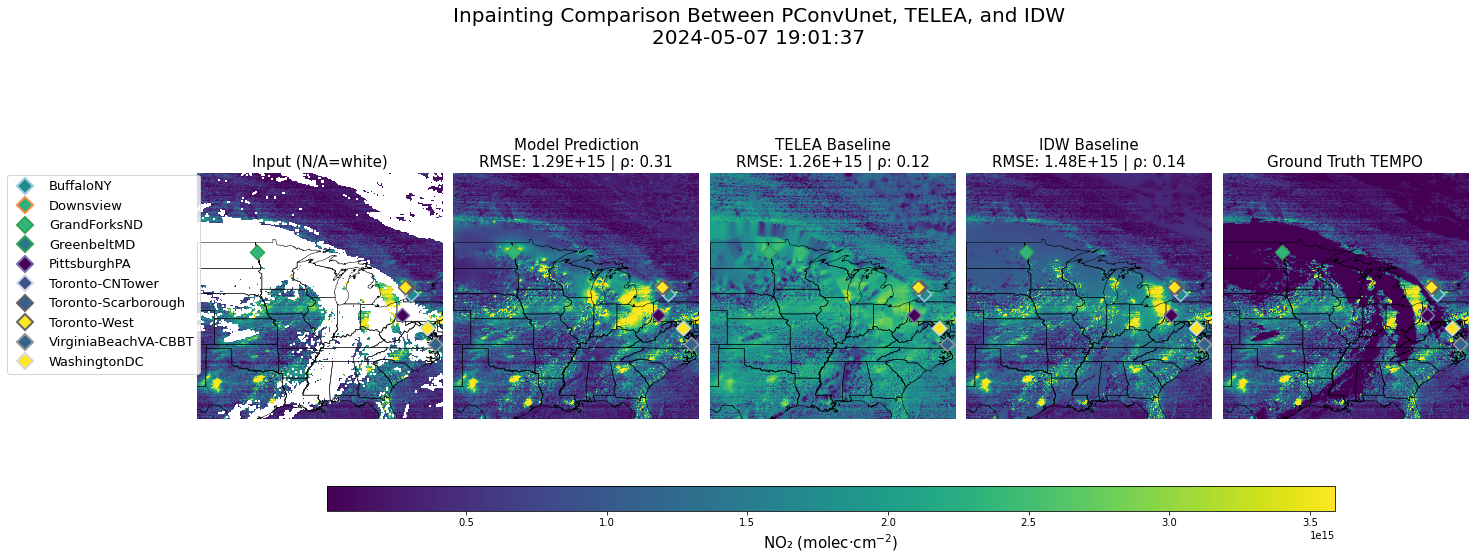

In [5]:
from scipy.spatial import cKDTree
import cv2
# ---- baselines ----
def telea_inpaint(image, mask):
    img8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    hole_mask = (mask == 0).astype(np.uint8)
    filled = cv2.inpaint(img8, hole_mask, 3, cv2.INPAINT_TELEA)
    return filled.astype(np.float32) / 255.0

def idw_inpaint(image, known, power=2):
    y, x = np.indices(image.shape)
    known_pts = np.column_stack(np.nonzero(known))
    if len(known_pts) == 0: return image
    known_vals = image[known_pts[:, 0], known_pts[:, 1]]
    filled = image.copy()
    missing_pts = np.column_stack(np.nonzero(~known))
    for r, c in missing_pts:
        dist2 = (known_pts[:, 0]-r)**2 + (known_pts[:, 1]-c)**2
        dist2[dist2 == 0] = 1e-6
        w = 1 / (dist2 ** (power/2))
        w /= np.sum(w)
        filled[r, c] = np.sum(w * known_vals)
    return filled


# ---- visualization ----
def visualize_sample_or_batch(
    sample=None,
    dataloader=None,
    batch_idx=0,
    sample_idx=0,
    model=None,
    normalizer=None,
    device="cuda",
    inference=True,
    shp_path=None,
    pandora_df=None,
    station_color_map=None,
    save=False,
    save_path="comparison_model_telea_idw.png"
):
    """Visualize Model, TELEA, and IDW predictions with Pandora overlays."""

    if sample is None and dataloader is not None:
        for i, batch in enumerate(dataloader):
            if i == batch_idx: break
        sample = {k: (v[sample_idx] if isinstance(v, torch.Tensor) else v)
                  for k, v in batch.items()}
    if sample is None:
        raise ValueError("Must provide sample or dataloader.")

    masked = sample["masked_img"][0].numpy()
    target = sample["target"][0].numpy()
    known_mask = sample["known_mask"][0].numpy().astype(bool)
    
    
    if hasattr(normalizer, "denormalize_image"):
        masked = normalizer.denormalize_image(masked)
        target = normalizer.denormalize_image(target)
        
        
    path = sample["path"][0]
    date_str = path.split("/")[-1].split(".")[0]
    date = datetime.strptime(date_str[:14], "%Y%m%d%H%M%S")
    with rasterio.open(path) as src:
        tr, crs = src.transform, src.crs
        H, W = src.height, src.width
    xmin, ymin, xmax, ymax = array_bounds(H, W, tr)
    segments = load_shapefile_segments_pyshp(shp_path, crs) if shp_path else []
    ts = date

    p_val_map = sample.get("p_val_mask", None)
    if p_val_map is not None and torch.is_tensor(p_val_map):
        p_val_map = p_val_map.numpy().astype(np.float64)
        p_val_map[p_val_map == 0.0] = np.nan

    model_pred = None
    if inference and model is not None:
        model.eval()
        with torch.no_grad():
            img = sample["masked_img"].unsqueeze(0).to(device)
            mask = sample["known_mask"].unsqueeze(0).to(device)
            pred, _ = model(img, mask)
            model_pred = normalizer.denormalize_image(pred[0, 0].cpu().numpy())
            
    
    img_norm = sample["masked_img"][0].numpy().astype(np.float32)          # normalized
    known_mask = sample["known_mask"][0].numpy().astype(bool)

    telea_pred_norm = telea_inpaint(img_norm, known_mask)
    t_pred = normalizer.denormalize_image(telea_pred_norm)
    idw_pred = idw_inpaint(masked, known_mask)
    
    
    pred_np_final = None
    pred_idw_final = None
    pred_tel_final = None
    pandora_rmse = None
    pandora_rho  = None


    pred_np_final = model_pred.copy()
    pred_idw_final = idw_pred.copy()
    pred_tel_final = t_pred.copy()

    pred_tel_final[~mask[0,0].cpu().numpy().astype(bool)] = t_pred[~mask[0,0].cpu().numpy().astype(bool)]
    pred_idw_final[~mask[0,0].cpu().numpy().astype(bool)] = idw_pred[~mask[0,0].cpu().numpy().astype(bool)]
    pred_np_final[~mask[0,0].cpu().numpy().astype(bool)] = model_pred[~mask[0,0].cpu().numpy().astype(bool)]
    # Pandora RMSE/ρ
    p_mask = sample.get("p_mask", torch.zeros_like(sample["known_mask"])).numpy().astype(bool)
    if p_mask.any():
        pandora_rows, pandora_cols = np.where(p_mask)
        pandora_values = p_val_map[pandora_rows, pandora_cols]
 
        pred_at_pandora = pred_np_final[pandora_rows, pandora_cols]
        idw_at_pandora = pred_idw_final[pandora_rows, pandora_cols]
        tel_at_pandora = pred_tel_final[pandora_rows, pandora_cols]
        
        valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
        valid_idw_mask = np.isfinite(pandora_values) & np.isfinite(idw_at_pandora)
        valid_tel_mask = np.isfinite(pandora_values) & np.isfinite(tel_at_pandora)
        
        if valid_mask.sum() > 0:
            pandora_valid = pandora_values[valid_mask]
            pred_valid = pred_at_pandora[valid_mask]
            pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
            from scipy import stats
            pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
        
        if valid_idw_mask.sum() > 0:
            pandora_valid = pandora_values[valid_idw_mask]
            pred_valid_idw = idw_at_pandora[valid_idw_mask]
            pandora_rmse_idw = np.sqrt(np.mean((pandora_valid - pred_valid_idw) ** 2))
            pandora_rho_idw, _ = stats.spearmanr(pandora_valid, pred_valid_idw)
        
        if valid_tel_mask.sum() > 0:
            pandora_valid = pandora_values[valid_tel_mask]
            pred_valid_tel = tel_at_pandora[valid_tel_mask]
            pandora_rmse_tel = np.sqrt(np.mean((pandora_valid - pred_valid_tel) ** 2))
            pandora_rho_tel, _ = stats.spearmanr(pandora_valid, pred_valid_tel)

    # ---------- 4. color scale ----------
    finite_vals = target[np.isfinite(target)]
    vmin, vmax = np.percentile(finite_vals, [2, 98]) if finite_vals.size else (0, 1)
    cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

    # ---------- 5. Pandora overlay helpers ----------
    def _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax, cmap_v,
                              pandora_df, station_color_map, add_legend=False, pred_np_final=None):
        legend_handles = []
        if pandora_df is None or ts is pd.NaT: return legend_handles

        dfw = pandora_df[(pandora_df["datetime"] >= ts - pd.Timedelta("30min")) &
                         (pandora_df["datetime"] <= ts + pd.Timedelta("30min"))].copy()
        if dfw.empty: return legend_handles
        if "station" in dfw.columns:
            dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
            dfw = dfw.sort_values(["station","abs_dt"]).groupby("station",as_index=False).first()

        lons = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
        lats = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
        ok = np.isfinite(lons)&np.isfinite(lats)&(lats>=-90)&(lats<=90)
        dfw = dfw.loc[ok]
        rr, cc = _lonlat_to_rowcol_vec(lons[ok], lats[ok], tr, crs)
        labels = dfw["station"].astype(str).to_numpy()

        rr_i, cc_i = rr.astype(int), cc.astype(int)
        ok_in = (rr_i>=0)&(rr_i<H)&(cc_i>=0)&(cc_i<W)
        rr_i, cc_i, labels = rr_i[ok_in], cc_i[ok_in], labels[ok_in]
        if rr_i.size==0: return legend_handles
        xs, ys = _rowcol_to_xy_vec(rr_i, cc_i, tr)

        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        p_val_arr = np.array(p_val_map, dtype=np.float64)
        p_val_arr[p_val_arr==0.0]=np.nan
        valid_mask = np.isfinite(p_val_arr)
        if not np.any(valid_mask): return legend_handles
        valid_coords = np.argwhere(valid_mask)
        valid_values = p_val_arr[valid_mask]
        tree = cKDTree(valid_coords)

        for x,y,lab,r,c in zip(xs,ys,labels,rr_i,cc_i):
            outline_color = station_color_map.get(lab,"red") if station_color_map else "red"
            dist, idx = tree.query(np.array([r,c]))
            pandora_val = valid_values[idx]
            fill_color = cmap_v(norm(pandora_val)) if np.isfinite(pandora_val) else "black"
            ax.scatter(x, y, s=100, marker="D", facecolor=fill_color,
                       edgecolor=outline_color, linewidth=1.5, zorder=6)
            if add_legend:
                label = lab
                if pred_np_final is not None and np.isfinite(pandora_val):
                    pred_val = pred_np_final[r,c]
                    if np.isfinite(pred_val):
                        rmse = np.sqrt((pandora_val - pred_val)**2)
#                         label += f"\nRMSE={rmse:.2E}"
                proxy = Line2D([0],[0], marker="D", color="none",
                               markerfacecolor=fill_color,
                               markeredgecolor=outline_color, markeredgewidth=2,
                               markersize=9, label=label)
                legend_handles.append(proxy)
        return legend_handles

    def add_pandora_stations(ax, add_legend=True, pred_np_final=None):
        return _add_pandora_stations(ax, tr, crs, H, W, ts, p_val_map, vmin, vmax,
                                     cmap_v, pandora_df, station_color_map,
                                     add_legend=add_legend, pred_np_final=pred_np_final)


    # ---------- 7. Panels: Input, Model, IDW, Target (explicit axes) ----------
    fig, ax = plt.subplots(1, 5, figsize=(20, 7))
    disp_inp = np.ma.masked_invalid(np.ma.array(masked, mask=~known_mask))
    im0 = ax[0].imshow(disp_inp,cmap=cmap_v,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
    ax[0].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[0].set_xlim(xmin, xmax);ax[0].set_ylim(ymin, ymax)
    ax[0].set_aspect("equal", adjustable="box")
    ax[0].set_title("Input (N/A=white)", fontsize=15, color="black")
    ax[0].axis("off")
    legend_handles = add_pandora_stations(ax[0], add_legend=True, pred_np_final=masked)

    # ---------- Panel 1: Model prediction ----------
    if inference and model_pred is not None:
        disp_model = np.ma.masked_invalid(model_pred)
        im1 = ax[1].imshow(disp_model,cmap=cmap_v, vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
        add_pandora_stations(ax[1], add_legend=False, pred_np_final=model_pred)
        ax[1].set_title(f"Model Prediction\nRMSE: {pandora_rmse:.2E} | ρ: {pandora_rho:.2f}", fontsize=15, color="black")
    else:
        im1 = ax[1].imshow(np.ma.array(target, mask=~np.isfinite(target)),cmap=cmap_v, vmin=vmin, vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
        add_pandora_stations(ax[1], add_legend=False)
        ax[1].set_title("Original TEMPO Data", fontsize=15)
    ax[1].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[1].axis("off")

    # ---------- Panel 2: TEL baseline ----------
    disp_tel = np.ma.masked_invalid(t_pred)
    im2 = ax[2].imshow(
        disp_tel,
        cmap=cmap_v,
#         vmin=vmin,
#         vmax=vmax,
        extent=[xmin, xmax, ymin, ymax],
        origin="upper",
    )
    add_pandora_stations(ax[2], add_legend=False, pred_np_final=t_pred)
    ax[2].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[2].set_title(f"TELEA Baseline\nRMSE: {pandora_rmse_tel:.2E} | ρ: {pandora_rho_tel:.2f}", fontsize=15, color="black")
    ax[2].axis("off")

    
    # ---------- Panel 3: IDW baseline ----------
    disp_idw = np.ma.masked_invalid(idw_pred)
    im3 = ax[3].imshow(
        disp_idw,
        cmap=cmap_v,
        vmin=vmin,
        vmax=vmax,
        extent=[xmin, xmax, ymin, ymax],
        origin="upper",
    )
    add_pandora_stations(ax[3], add_legend=False, pred_np_final=idw_pred)
    ax[3].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[3].set_title(f"IDW Baseline\nRMSE: {pandora_rmse_idw:.2E} | ρ: {pandora_rho_idw:.2f}", fontsize=15, color="black")
    ax[3].axis("off")
    
    # ---------- Panel 3: Target ----------
    disp_targ = np.ma.masked_invalid(target)
    im3 = ax[4].imshow(disp_targ,cmap=cmap_v,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax],origin="upper")
    add_pandora_stations(ax[4], add_legend=False, pred_np_final=target)
    ax[4].add_collection(LineCollection(segments, colors="k", linewidths=0.5))
    ax[4].set_title("Ground Truth TEMPO", fontsize=15, color="black")
    ax[4].axis("off")

    if legend_handles:ax[0].legend(handles=legend_handles,bbox_to_anchor=(-0.80, 1.02),loc="upper left",frameon=True,fontsize=13,markerscale=1.2)
    cbar_ax = fig.add_axes([0.2, 0.0001, 0.7, 0.05])  # [left, bottom, width, height]
    cbar_ax.tick_params(axis="x", colors="black", labelcolor="black")
    fig.colorbar(im1, cax=cbar_ax, orientation="horizontal").set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15, color="black")
    plt.suptitle(f"Inpainting Comparison Between PConvUnet, TELEA, and IDW\n{date.strftime('%Y-%m-%d %H:%M:%S')}\n", fontsize=20, y=1.0, color="black")
    plt.tight_layout()
    if save:plt.savefig(save_path or "comparison_idw_tel.png", dpi=300, bbox_inches="tight", facecolor='white', transparent=False)
    plt.show()
    plt.close()

visualize_sample_or_batch(
    dataloader=val_loader,
    batch_idx=37, sample_idx=0,
    model=model,
    normalizer=normalizer,
    device="cuda",
    shp_path=shp_path,
    pandora_df=pandora_df,
    station_color_map=station_color_map,
    inference=True,
    save=False)

In [12]:
import numpy as np
from scipy import stats
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

def eval_pandora_metrics_modelavg(model, normalizer, dataloader, device="cuda", alpha=0.6):
    """
    Evaluate Pandora metrics for model averaging between the trained model
    and Telea inpainting results:
        total_pred = alpha * model_pred + (1 - alpha) * telea_pred
    Computes RMSE, Spearman rho, and Pearson r for each sample.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Pandora (Model + Telea Avg)"):
            B = batch["masked_img"].shape[0]

            for b in range(B):
                # --- 1. Extract batch tensors ---
                img        = batch["masked_img"][b:b+1].to(device)       # [1,1,H,W]
                mask       = batch["known_mask"][b:b+1].to(device)       # [1,1,H,W]
                target     = batch["target"][b:b+1].to(device)
                telea_pred = batch.get("telea_pred", None)
                if telea_pred is None:
                    continue
                telea_pred = telea_pred[b:b+1].to(device)

                # --- 2. Model forward pass ---
                model_pred, _ = model(img, mask)

                # --- 3. Combine model + Telea ---
                total_pred = alpha * model_pred + (1 - alpha) * telea_pred

                # --- 4. Convert to numpy + denormalize ---
                pred_np = total_pred[0, 0].cpu().numpy()
                tgt_np  = target[0, 0].cpu().numpy()
                if hasattr(normalizer, "denormalize_image"):
                    pred_np = normalizer.denormalize_image(pred_np)
                    tgt_np  = normalizer.denormalize_image(tgt_np)

                # optional smoothing
                pred_np = gaussian_filter(pred_np, sigma=0.5)

                # --- 5. Pandora comparison ---
                p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
                p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

                pandora_rmse = pandora_rho = pandora_r = bias = None
                n_pandora = 0

                if p_mask.any():
                    rows, cols = np.where(p_mask)
                    pandora_values = p_val_map[rows, cols]

                    # Denormalize Pandora values
                    if hasattr(normalizer, 'denormalize_pandora_array'):
                        pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                    elif hasattr(normalizer, 'denormalize_pandora'):
                        pandora_values = np.array(
                            [normalizer.denormalize_pandora(v) for v in pandora_values]
                        )

                    pred_at_pandora = pred_np[rows, cols]
                    valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)

                    if np.any(valid_mask):
                        pandora_valid = pandora_values[valid_mask]
                        pred_valid = pred_at_pandora[valid_mask]
                        n_pandora = len(pandora_valid)

                        pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                        bias = np.mean(pred_valid - pandora_valid)

                        if len(pandora_valid) > 1:
                            pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                            pandora_r, _ = stats.pearsonr(pandora_valid, pred_valid)

                results.append({
                    "rho": pandora_rho,
                    "r": pandora_r,
                    "rmse": pandora_rmse,
                    "bias": bias,
                    "n_pandora": n_pandora
                })

    # ---- Aggregate ----
    def safe_mean(vals):
        vals = [v for v in vals if v is not None and not np.isnan(v)]
        return np.nan if len(vals) == 0 else float(np.nanmean(vals))

    avg_rho  = safe_mean([m["rho"] for m in results])
    avg_r    = safe_mean([m["r"] for m in results])
    avg_rmse = safe_mean([m["rmse"] for m in results])
    avg_bias = safe_mean([m["bias"] for m in results])

    print(f"\n=== Pandora Validation Metrics @ alpha: {alpha} ===")
    print(f"Avg Spearman ρ : {avg_rho:.3f}")
    print(f"Avg Pearson  r : {avg_r:.3f}")
    print(f"Avg RMSE       : {avg_rmse:.4E}")
    print(f"Avg Bias       : {avg_bias:.4E}")

    return results, {
        "rho": avg_rho,
        "r": avg_r,
        "rmse": avg_rmse,
        "bias": avg_bias
    }

alphas = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in alphas:
    results, summary = eval_pandora_metrics_modelavg(model, normalizer, val_loader, device="cuda", alpha=i)

Evaluating Pandora (Model + Telea Avg):   0%|          | 0/208 [00:00<?, ?it/s]


=== Pandora Validation Metrics @ alpha: 0.3 ===
Avg Spearman ρ : 0.445
Avg Pearson  r : 0.447
Avg RMSE       : 2.1945E+15
Avg Bias       : -7.1856E+14


Evaluating Pandora (Model + Telea Avg):   0%|          | 0/208 [00:00<?, ?it/s]


=== Pandora Validation Metrics @ alpha: 0.4 ===
Avg Spearman ρ : 0.444
Avg Pearson  r : 0.448
Avg RMSE       : 2.1628E+15
Avg Bias       : -6.2031E+14


Evaluating Pandora (Model + Telea Avg):   0%|          | 0/208 [00:00<?, ?it/s]


=== Pandora Validation Metrics @ alpha: 0.5 ===
Avg Spearman ρ : 0.443
Avg Pearson  r : 0.448
Avg RMSE       : 2.1511E+15
Avg Bias       : -5.0577E+14


Evaluating Pandora (Model + Telea Avg):   0%|          | 0/208 [00:00<?, ?it/s]


=== Pandora Validation Metrics @ alpha: 0.6 ===
Avg Spearman ρ : 0.444
Avg Pearson  r : 0.448
Avg RMSE       : 2.1675E+15
Avg Bias       : -3.7339E+14


Evaluating Pandora (Model + Telea Avg): 100%|██████████| 208/208 [02:08<00:00,  1.62it/s]


=== Pandora Validation Metrics @ alpha: 0.7 ===
Avg Spearman ρ : 0.442
Avg Pearson  r : 0.448
Avg RMSE       : 2.2205E+15
Avg Bias       : -2.2122E+14


In [8]:
import numpy as np
from scipy import stats
from scipy.ndimage import gaussian_filter
import cv2
def eval_pandora_metrics_idw(normalizer, dataloader):
    """
    Evaluate the IDW baseline using Pandora stations as validation points.
    Computes RMSE, Spearman rho, and Pearson r for each sample.
    """
    results = []

    for batch in tqdm(dataloader):
        B = batch["masked_img"].shape[0]
        for b in range(B):
            # --- 1. Extract numpy arrays ---
            img = batch["masked_img"][b, 0].cpu().numpy()        # (H,W)
            target = batch["target"][b, 0].cpu().numpy()         # (H,W)
            mask_obs = batch["known_mask"][b, 0].cpu().numpy() > 0.5  # (H,W) boolean

            # --- 2. Run IDW inpainting ---
            pred_np = telea_inpaint(img, mask_obs)

            # --- 3. Denormalize both ---
            if hasattr(normalizer, "denormalize_image"):
                pred_np = normalizer.denormalize_image(pred_np)
                tgt_np = normalizer.denormalize_image(target)
            else:
                tgt_np = target
                
#             plt.imshow(pred_np)
#             plt.show()

            # Optional smoothing to match CNN output
            pred_np = gaussian_filter(pred_np, sigma=0.5)

            # --- 4. Pandora comparison ---
            p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
            p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

            pandora_rmse, pandora_rho, pandora_r, n_pandora = None, None, None, 0
            if p_mask.any():
                rows, cols = np.where(p_mask)
                pandora_values = p_val_map[rows, cols]

                # Denormalize Pandora values
                if hasattr(normalizer, 'denormalize_pandora_array'):
                    pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                elif hasattr(normalizer, 'denormalize_pandora'):
                    pandora_values = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])

                pred_at_pandora = pred_np[rows, cols]
                valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)

                if np.any(valid_mask):
                    pandora_valid = pandora_values[valid_mask]
                    pred_valid = pred_at_pandora[valid_mask]

                    pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid) ** 2))
                    if len(pandora_valid) > 1:
                        pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                        pandora_r, _ = stats.pearsonr(pandora_valid, pred_valid)
                    n_pandora = len(pandora_valid)

#                 print(pandora_rho, pandora_rmse, pandora_r)
            results.append({
                "rho": pandora_rho,
                "rmse": pandora_rmse,
                "n_pandora": n_pandora,
                "r": pandora_r
            })

    return results
idw_metrics = eval_pandora_metrics_idw(normalizer, val_loader)

# Aggregate results safely
all_rhos  = [m["rho"] for m in idw_metrics if m["rho"] is not None]
all_rmses = [m["rmse"] for m in idw_metrics if m["rmse"] is not None]
all_rs    = [m["r"] for m in idw_metrics if m["r"] is not None]

print(f"Avg Spearman ρ: {np.nanmean(all_rhos):.3f}")
print(f"Avg RMSE:       {np.nanmean(all_rmses):.4E}")
print(f"Avg Pearson r:  {np.nanmean(all_rs):.3f}")


  0%|          | 1/208 [00:01<05:29,  1.59s/it]


KeyboardInterrupt: 

In [11]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy import stats

def eval_pandora_metrics(model, normalizer, dataloader, device="cuda"):
    """
    Iterate over dataloader, compute Pandora RMSE and Spearman rho for each sample.
    Returns list of dicts with metrics for each sample.
    """
    model.eval()
    results = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            B = batch["masked_img"].shape[0]
            for b in range(B):
                # Extract single sample
                img = batch["masked_img"][b:b+1].to(device)       # [1,1,H,W]
                target = batch["target"][b:b+1].to(device)
                mask_obs = batch["known_mask"][b:b+1].to(device)

                if "known_and_fake_mask" in batch:
                    mask = batch["known_and_fake_mask"][b:b+1].to(device)
                else:
                    mask = mask_obs

                # Model prediction
                pred, _ = model(img, mask)

                # Denormalize
                pred_np = normalizer.denormalize_image(pred[0,0].cpu().numpy())
                tgt_np = normalizer.denormalize_image(target[0,0].cpu().numpy())

                # Smooth prediction
                pred_np = gaussian_filter(pred_np, sigma=0.5)

                # Pandora data
                p_mask = batch.get("p_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy().astype(bool)
                p_val_map = batch.get("p_val_mask", torch.zeros_like(batch["known_mask"]))[b].cpu().numpy()

                pandora_rmse, pandora_rho, pandora_r, n_pandora = None, None, None, 0
                if p_mask.any():
                    rows, cols = np.where(p_mask)
                    if len(rows) > 0:
                        pandora_values = p_val_map[rows, cols]

                        # Denormalize Pandora if possible
                        if hasattr(normalizer, 'denormalize_pandora_array'):
                            pandora_values = normalizer.denormalize_pandora_array(pandora_values)
                        elif hasattr(normalizer, 'denormalize_pandora'):
                            pandora_values = np.array([normalizer.denormalize_pandora(v) for v in pandora_values])

                        pred_at_pandora = pred_np[rows, cols]

                        valid_mask = np.isfinite(pandora_values) & np.isfinite(pred_at_pandora)
                        if valid_mask.sum() > 0:
                            pandora_valid = pandora_values[valid_mask]
                            pred_valid = pred_at_pandora[valid_mask]

                            pandora_rmse = np.sqrt(np.mean((pandora_valid - pred_valid)**2))
                            if len(pandora_valid) > 1:
                                pandora_rho, _ = stats.spearmanr(pandora_valid, pred_valid)
                                pandora_r, _ = stats.pearsonr(pandora_valid, pred_valid)
                            n_pandora = len(pandora_valid)
#                         print(pandora_rho, pandora_rmse, pandora_r)
                results.append({
                    "rho": pandora_rho,
                    "rmse": pandora_rmse,
                    "n_pandora": n_pandora,
                    "r":pandora_r
                })

    return results
metrics = eval_pandora_metrics(model, normalizer, val_loader, device="cuda")

# For example, aggregate results
all_rhos  = [m["rho"] for m in metrics if m["rho"] is not None]
all_rmses = [m["rmse"] for m in metrics if m["rmse"] is not None]
all_rs = [m["r"] for m in metrics if m["r"] is not None]

print(f"Avg rho:  {np.nanmean(all_rhos):.3f}")
print(f"Avg RMSE: {np.nanmean(all_rmses):.4E}")
print(f"Avg r:  {np.nanmean(all_rs):.3f}")



100%|██████████| 208/208 [02:11<00:00,  1.58it/s]

Avg rho:  0.441
Avg RMSE: 2.6886E+15
Avg r:  0.443


In [6]:
import torchvision.transforms.functional as TF

def _dilate_mask(bin_mask, k=3):
    """bin_mask: [B,1,H,W], 0/1. Returns dilated binary mask."""
    pad = k // 2
    kernel = torch.ones(1, 1, k, k, device=bin_mask.device, dtype=bin_mask.dtype)
    hits = F.conv2d(bin_mask, kernel, padding=pad)
    return (hits > 0).float()

def _finite_diff_xy(x):
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    return dy, dx

def boundary_ring_loss(pred, target, hole_mask, ring_width=5, w_val=1.0, w_grad=1.0, eps=1e-8):
    """
    pred/target: [B,1,H,W], hole_mask: [B,1,H,W] with 1=hole, 0=known.
    """
    hole = (hole_mask > 0.5).float()
    ring = _dilate_mask(hole, k=ring_width) - hole
    ring = (ring > 0.5).float()  # [B,1,H,W]

    # value continuity on ring
    val_err = torch.abs(pred - target) * ring
    val_term = val_err.sum() / (ring.sum() + eps)

    # gradient continuity on ring (align overlapping pixels)
    dy_p, dx_p = _finite_diff_xy(pred)
    dy_t, dx_t = _finite_diff_xy(target)

    ring_y = ring[:, :, 1:, :] * ring[:, :, :-1, :]
    ring_x = ring[:, :, :, 1:] * ring[:, :, :, :-1]

    gy = torch.abs(dy_p - dy_t) * ring_y
    gx = torch.abs(dx_p - dx_t) * ring_x
    grad_term = (gy.sum() + gx.sum()) / (ring_y.sum() + ring_x.sum() + eps)

    return w_val * val_term + w_grad * grad_term

def gradient_loss(pred, target, mask=None):
    """Penalize large gradients to encourage smoothness"""
    # Calculate gradients
    dy_pred, dx_pred = torch.gradient(pred, dim=(-2, -1))
    dy_target, dx_target = torch.gradient(target, dim=(-2, -1))
    
    if mask is not None:
        # Only calculate loss in valid regions
        mask_expanded = mask.expand_as(dy_pred)
        dy_pred = dy_pred * mask_expanded
        dx_pred = dx_pred * mask_expanded
        dy_target = dy_target * mask_expanded
        dx_target = dx_target * mask_expanded
    
    # L1 loss on gradients
    grad_loss = F.l1_loss(dy_pred, dy_target) + F.l1_loss(dx_pred, dx_target)
    return grad_loss

def total_variation_loss(pred, mask=None):
    """Total variation loss for smoothness"""
    dy = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
    dx = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
    
    if mask is not None:
        # Apply mask to gradients
        mask_y = mask[:, :, 1:, :] * mask[:, :, :-1, :]
        mask_x = mask[:, :, :, 1:] * mask[:, :, :, :-1]
        dy = dy * mask_y
        dx = dx * mask_x
    
    return torch.mean(dy) + torch.mean(dx)

def improved_loss_progress(pred, target, mask, known_mask, epoch, max_epochs):
#     hole_mask = (mask == 0).float()
    hole_mask = ((known_mask == 1) & (mask == 0)).float()

    l1_loss = F.l1_loss(pred * hole_mask, target * hole_mask)
#     grad_loss = gradient_loss(pred, target, mask)
    tv_loss   = total_variation_loss(pred, mask)
    L_ring    = boundary_ring_loss(pred, target, hole_mask, ring_width=3)

    loss_hf = (
        1.0  * highfreq_loss(pred, target, sigma=1) +
        0.5  * highfreq_loss(pred, target, sigma=2) +
        0.25 * highfreq_loss(pred, target, sigma=4)
    )

    # --- Progress factor ---
    frac = min(epoch / max_epochs, 1.0)

    # --- Stage weighting ---
    w_l1   = 1.0 - 0.3*frac          # decay L1 over time
#     w_grad = 0.05 + 0.05*frac
    w_tv   = 0.005 + 0.05*frac
    w_ring = 0.0 + 0.2*frac
    w_hf   = 0.1 + 0.2*frac

    # --- Combine ---
    total_loss = (
        w_l1   * l1_loss +
#         w_grad * grad_loss +
        w_tv   * tv_loss +
        w_ring * L_ring +
        w_hf   * loss_hf
    )

    return total_loss, l1_loss, tv_loss, L_ring, loss_hf



def highfreq_loss(pred, target, sigma=6):
    # Kernel size should be odd and ≈ 6*sigma
    ksize = int(2 * round(3 * sigma) + 1)

    # Apply Gaussian blur
    pred_lp = TF.gaussian_blur(pred, kernel_size=ksize, sigma=sigma)
    target_lp = TF.gaussian_blur(target, kernel_size=ksize, sigma=sigma)

    # High-pass residuals
    pred_hp = pred - pred_lp
    target_hp = target - target_lp

    return F.l1_loss(pred_hp, target_hp)


100%|██████████| 830/830 [22:35<00:00,  1.63s/it]


Epoch 1/150 | Total 0.2034 | L1 0.0889 | TV 0.1299 | Ring 3.7243 | HF 1.1384 | Pandora bias -3014769883742208.0000
2024-06-12 11:50:08


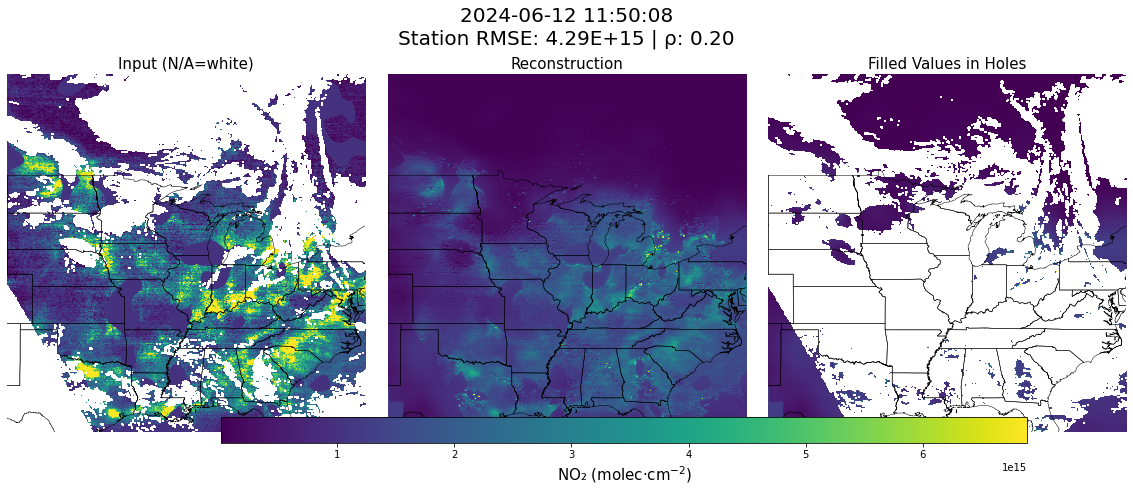

  0%|          | 0/830 [00:00<?, ?it/s]

Epoch 2/150 | Total 0.1917 | L1 0.0813 | TV 0.3893 | Ring 3.3877 | HF 1.0261 | Pandora bias -3008096846741504.0000


 84%|████████▍ | 697/830 [17:36<03:21,  1.52s/it]

In [ ]:
def train_model(model, normalizer, train_loader, shp_path, epochs=200, patience=20):
    opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    best_l1 = float("inf")
    best_state = None
    wait = 0
    history = []
    bias_threshold = 0.05  # tolerance for Pandora bias (adjust as needed)

    for epoch in range(epochs):
        train_loader.dataset.current_epoch = epoch
        train_loader.dataset.max_epochs = epochs

        model.train()
        train_loss = train_l1 = train_tv = train_ring = train_hf = 0.0
        pandora_biases = []

        for batch in tqdm(train_loader):
            img        = batch["masked_img"].cuda()
            mask_aug   = batch["fake_mask"].cuda()       # 1=keep, 0=artificial hole
            known_mask = batch["known_mask"].cuda()      # 1=valid TEMPO pixel
            target     = batch["target"].cuda()
            telea_pred = batch.get("telea_pred", None)
            p_mask     = batch.get("p_mask", None)
            p_val_map  = batch.get("p_val_mask", None)

            pred, _ = model(img, mask_aug)

            # --- Optional Telea averaging ---
            if telea_pred is not None:
                telea_pred = telea_pred.cuda()
                alpha = 0.5
                pred = alpha * pred + (1 - alpha) * telea_pred

            # --- Compute loss (only on valid + artificial gaps) ---
            total_loss, l1_loss, tv_loss, L_ring, loss_hf = improved_loss_progress(
                pred, target, mask_aug, known_mask, epoch, max_epochs=epochs
            )

            opt.zero_grad()
            total_loss.backward()
            opt.step()

            train_loss += total_loss.item()
            train_l1   += l1_loss.item()
            train_tv   += tv_loss.item()
            train_ring += L_ring.item()
            train_hf   += loss_hf.item()

            if p_mask is not None and p_val_map is not None and torch.any(p_mask > 0):
                p_mask = p_mask.cuda().unsqueeze(1)      # [B,1,H,W]
                p_val_map = p_val_map.cuda().unsqueeze(1)

                pred_vals = pred[p_mask.bool()].detach().cpu().numpy()
                obs_vals  = p_val_map[p_mask.bool()].detach().cpu().numpy()

                if pred_vals.size > 0:
                    pandora_biases.append(np.nanmean(pred_vals - obs_vals))


        # ---- Epoch means ----
        n_batches = len(train_loader)
        train_loss /= n_batches
        train_l1   /= n_batches
        train_tv   /= n_batches
        train_ring /= n_batches
        train_hf   /= n_batches
        pandora_bias = np.nanmean(pandora_biases) if len(pandora_biases) > 0 else np.nan

        print(f"Epoch {epoch+1}/{epochs} | Total {train_loss:.4f} | L1 {train_l1:.4f} | TV {train_tv:.4f} "
              f"| Ring {train_ring:.4f} | HF {train_hf:.4f} | Pandora bias {pandora_bias:.4f}")

        # ---- Early stopping on reconstruction + bias stabilization ----
        if (train_l1 < best_l1) and (np.isnan(pandora_bias) or abs(pandora_bias) < bias_threshold):
            best_l1 = train_l1
            best_state = model.state_dict().copy()
            wait = 0
            torch.save(model.state_dict(), f"pconvunet_best.pt")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1} (no L1 improvement or bias stable)")
                break

        # ---- Log history ----
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "l1": train_l1,
            "tv": train_tv,
            "ring": train_ring,
            "hf": train_hf,
            "pandora_bias": pandora_bias,
        })

        # ---- Optional visualization every few epochs ----
        if epoch % 5 == 0:
            visualize_sample_or_batch(
                dataloader=train_loader,
                batch_idx=0, sample_idx=0,
                model=model,
                normalizer=normalizer,
                device="cuda",
                shp_path=shp_path,
                inference=True, train=True, save=False
            )

        # ---- Write training history ----
        with open("csv_history.csv", "w", newline="") as f:
            csv_writer = csv.DictWriter(
                f, fieldnames=["epoch", "train_loss", "l1", "tv", "ring", "hf", "pandora_bias"]
            )
            csv_writer.writeheader()
            csv_writer.writerows(history)

    if best_state is not None:
        model.load_state_dict(best_state)
    return model



train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=custom_collate_fn  )

model = OriginalPlusMinimalAttentionDeepOld(base_ch=32).cuda()  # Your original + tiny attention
model = train_model(model, normalizer,train_loader, shp_path, epochs=150, patience=20)